In [1]:
# Import stuff
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import scipy
import scipy.stats as stats
import random

# p-values are unreliable

## Motivating example: Lindley's paradox
Imagine a city where 49,581 boys and 48,870 girls are born over a certain time period
What are the questions we can ask?

* What is the probability of a boy being born?
* Is a boy more likely to be born than a girl?
* What is the probability that the birth of a boy is more likely than the birth of a girl?
* What is the range that will contain 95 % of likely observed values?
* Should a prior hypothesis (for example, the probability of a boy being born is 0.5) be accepted of rejected?

## Typical statistics approach
Find $\mu_0$ and $\sigma_0$, the mean and std for the null hypothesis.

In [2]:
boys, girls = 49581, 48870 # Actual number
# Null hypothesis: boys = 0.5 * (boys+girls)
mu = 0.5 * (boys + girls)
sigma = (boys+girls)*0.5*(1-0.5) # This is actually sigma squared
print('Null hypothesis: mu = %.1f, sigma = %.2f' %(mu, sigma))

Null hypothesis: mu = 49225.5, sigma = 24612.75


Using a normal approximation,
$P(X>=x | \mu = \mu_0 ) $

In [ ]:
#$\int_{49581}^{98451} 1/(\sqrt{2 \pi \sigma^2) 
#                 \exp{-((\mu_{boys} - \mu_0)/\sigma)/2 $

In [3]:
# In code:
def normal_approximation(u, mu, sigma):
    return (1/(np.sqrt(2*np.pi*sigma))) * np.exp(-((u-mu)**2/(sigma))/2.)
P_mu = sum([normal_approximation(x, mu, sigma) for x in range(49581, 98451)])
P_mu = float(P_mu)
print('The raw probability of boys = mu_0: %.5f' %P_mu)
print('We can make it 2-sided since it would be equally surprising')
print('if girls != mu, in this case P(boys, girls != mu) : %.5f' %(P_mu*2.))

The raw probability of boys = mu_0: 0.01182
We can make it 2-sided since it would be equally surprising
if girls != mu, in this case P(boys, girls != mu) : 0.02365


Since 0.0237 < 0.05 we reject the null hypothesis,
meaning that the births of boys deviated significantly from 0.5.

What else can we say about these numbers given this approach? What is likelihood or confidence our result is correct? 

In fact, the *only* conclusion we can come to from this approach is:
* There is sufficient evidence to reject the hypothesis.
But we know better. The better approach is a Bayesian approach.

## We cannot (but are *tempted* to) say:
* There is a 2.4% chance the null hypothesis is true (2.4% chance of a 'fluke').
* There is a 2.4% chance the alternative hypothesis is false (false positive).
* A p-value of 0.024 is stronger evidence that replicating the experiment would yield the same conclusion.
* The p-value reflects the effect size.


## In fact, the p-value is extremely fickle

Imagine we have two datasets, both with means of 15 and stds of 2, such as below:

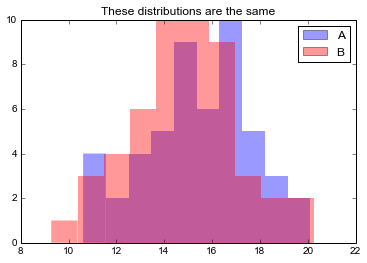

In [5]:
def gen_data(N=50, ngroups=2, mus=[15, 15.7], sigmas=[2,2]):
    """Generate some random data."""
    data = []
    for n in range(ngroups):
        data.append(np.random.normal(mus[n], sigmas[n], N))
    return data

# Two groups, group1 and group2
A, B = gen_data(N=50, ngroups=2, mus=[15.,15.], sigmas=[2.,2.])
# Show what these distributions look like
plt.hist(A, bins=10, facecolor='b', edgecolor='none', 
         alpha=0.4, label='A')
plt.hist(B, bins=10, facecolor='r', edgecolor='none', 
         alpha=0.4, label='B')
plt.title('These distributions are the same')
plt.legend()


Despite these distributions looking almost identical, I bet we can find differences between them. Just to show what we might already know, I'll find some p-values that are pretty egregious.

In [6]:
# This function demonstrates how fickle p-values can be.
def fickle(groups=None, N=10, sims=4, ret_p=False, show=True):
  """
  Two-group example of why p-value is unreliable.
  """
  if groups is None:
    A, B = gen_data(N*4, mus=[15,15]) # Dists must be moderately larger than samples
  # Both samples are drawn from the same dist.
  else:
    A, B = groups
  groups = []
  for s in range(sims):
    # Draw the samples
    a = [A[i] for i in [int(x) for x in np.random.random(N)*len(A)]]
    b = [B[i] for i in [int(x) for x in np.random.random(N)*len(B)]]
    groups.append([a,b])
  
  # Get the p-values
  p_vals = [stats.ttest_ind(t[0], t[1])[1] for t in groups]
  
  # If got more than 10 sims, find the largest, smallest, and 2 randos
  if sims > 10:
    keep = [p_vals.index(min(p_vals)), p_vals.index(max(p_vals)),
            int(np.random.random()*len(p_vals)),
            int(np.random.random()*len(p_vals))]
    groups = [groups[i] for i in keep]
    sims = len(keep)
  else:
    keep = [i for i in range(sims)]
    groups = [groups[i] for i in keep]
    sims = len(keep)

  if show:
    fig = plt.figure()
    for s in range(sims):
      ax = fig.add_subplot(1,sims, s+1)
      ax.plot(np.random.random(N)*.25, groups[s][0], 'o', color='b', 
              alpha=0.5, )
      ax.plot([i + 1 for i in np.random.random(N)*.25], groups[s][1], 
              'o', color='r', alpha=0.5, )
      ax.plot([0,.5], [np.mean(groups[s][0]), np.mean(groups[s][0])],
              linewidth=1.5, color='b', alpha=0.8)
      ax.plot([.75,1.25], [np.mean(groups[s][1]), np.mean(groups[s][1])],
              linewidth=1.5, color='r', alpha=0.8)
      ax.set_title('Sim: %i, P=%.3f' %(s+1, p_vals[keep[s]]))
      plt.xticks([0,1], ['A', 'B'])
      if s != 0:
        ax.yaxis.set_visible(False)
    
    plt.show()
  if ret_p:
    return p_vals
  return

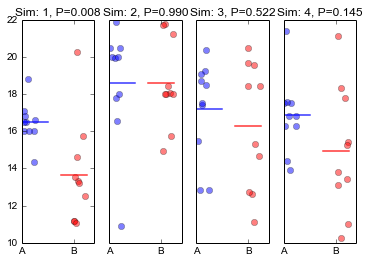

In [7]:
# Now, let's actually do it.
# A, B = gen_data(N=50, ngroups=2, mus=[15., 15.], sigmas=[2, 2])
fickle(groups=[A,B], sims=20)
# plt.hist(A, bins=5)

Of course, increasing sample size decreases the chances of finding spurious differences...

In [8]:
# This function examines sample sizes.
def sample_size(Ns=[10,30,64,100], sims=1000):
  """
  Examine the effect of sample size on p value (as a distribution).
  """
  dists = [fickle(N=i, sims=sims, ret_p=True, show=False) for i in Ns]
  
  # Plot the histograms of p values
  fig = plt.figure()
  for n in range(len(Ns)):
    ax = fig.add_subplot(1,len(Ns), n+1)
    logbins = np.logspace(-4, 0, 20)
    cnts, bins, patches = ax.hist(dists[n], bins=logbins, color='gray',
                                  edgecolor='white')
    
    # Figure out which bins are significant
    # cnts, _ = np.histogram(dists[n], bins=np.logspace(-4,0,20))
    bincents = 0.5 * (bins[:-1] + bins[1:])
    cols = []
    for b in bincents:
      if b <= 0.05:
        if b <= 0.01:
          if b <= 0.001:
            cols.append('red')
          else:
            cols.append('orange')
        else:
          cols.append('yellow')
      else:
        cols.append('gray')
    
    for c, p in zip(cols, patches):
      plt.setp(p, 'facecolor', c)
    
    ax.plot([0.05, 0.05], [0,max(cnts)], '-', color='r')
    ax.plot([0.01, 0.01], [0,max(cnts)], '-', color='gray')
    ax.plot([0.001, 0.001], [0,max(cnts)], '-', color='black')
    plt.gca().set_xscale('log')
    ax.set_title('Sample size: %i' %Ns[n])
    plt.xticks([0.0001, 0.001, 0.01, 0.1, 1],
                  ['0.0001', '0.001', '0.01', '0.1', '1'])
    ax.set_xlabel('P')
    
  plt.show()
  return


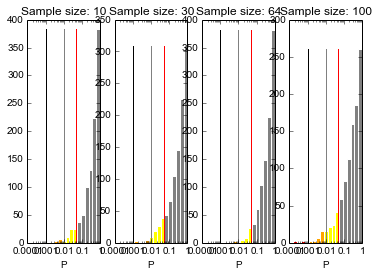

In [10]:
# Now test differences in sample sizes
sample_size()

P-values are inconsistent and unreliable, and the 'parametric' tests used to generate p-values are lazy and uninformative. There are alternatives...

# Randomization, bootstrap and Monte Carlo

*Randomization* is at the core of these non-parametric methods that can tell us much more than typical statistics. 

Randomization and bootstrapping allow sub-sampling and re-sampling of a dataset to determine the likelihood that observed effects are due to chance.

This approach preserves the original distributions (there is no need to invoke normal distributions or any other kind of priors) and is easy to use and not computationally intensive.

## Randomization: example

Mandible lengths of male and female golden jackals were collected and analyzed to see if a difference exists between the genders.

In [11]:
# Here is the raw data in cm
def jackaldata():
  data = [[120, 107, 110, 116, 114, 111, 113, 117, 114, 112], # males
          [110, 111, 107, 108, 110, 105, 107, 106, 111, 111]] # females
  return data

# Show the data from two groups
def show_data(groups, retax=False):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.random.random(len(groups[0]))*.25, 
             groups[0], 'o', color='b', alpha=0.5, )
    ax.plot([i + 1 for i in np.random.random(len(groups[1]))*.25], 
            groups[1], 'o', color='r', alpha=0.5, )
    ax.plot([-.125,.25], [np.mean(groups[0]), np.mean(groups[0])],
          linewidth=1.5, color='b', alpha=0.8)
    ax.plot([.875,1.25], [np.mean(groups[1]), np.mean(groups[1])],
          linewidth=1.5, color='r', alpha=0.8)
    ax.set_title('$\mu_1 - \mu_2$: %.2f' %(np.mean(groups[0])-np.mean(groups[1])))
    ax.set_xticks([0,1], ['A', 'B'])
    ax.set_xlim([-.25,1.5])
    # ax.set_ylim([0,5])
    if retax:
        return ax
    else:
        plt.show(); return

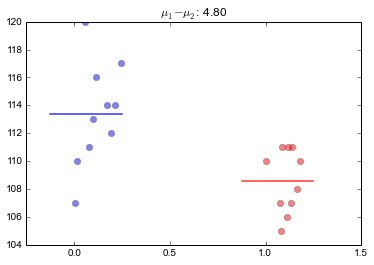

In [12]:
# Now let's look at our sample data
a, b = jackaldata()
show_data([a,b])

So naively we suspect there may be a difference in mandible lengths. We could run a parametric t-test. These tests are often a good idea because they are computationally efficient and can help flag a dataset for further analysis. 

Given the small sample size, we might not expect an extremely low p-value, but if we were screening lots of data we might be inclined to pursue a p-value of 0.1 or less.

In [13]:
t, p = stats.ttest_ind(a,b)
print('T-statistic: %.4f, p-value: %.4f' %(t, p))

T-statistic: 3.4843, p-value: 0.0026


Our approach for randomization is to pool the data together and then re-assemble the two groups randomly. If there were un-even sample sizes (a has 12 members and b has 16 members), we could preserve or disregard these differences.

We will try to generate many, many such "realizations" of the data. To make this efficient, we also need a test statistic that allows us to compare two groups. The most obvious choice here is difference of means.

In [14]:
# Test statistic: difference of means
def test_stat(groups):
    return np.mean(groups[0])-np.mean(groups[1])

# Randomnly combine group members
def scramble(groups):
    lenA, lenB = len(groups[0]), len(groups[1])
    pooled = list(groups[0])+list(groups[1])
    # Create the indexing lists for the new groups
    scram = []
    while len(scram) < len(pooled):
        ix = int(np.random.random(1)*len(pooled)) # No replacement
        if ix not in scram:
            scram.append(ix)
    randA = [pooled[scram[i]] for i in range(0,lenA)]
    randB = [pooled[scram[i]] for i in range(lenA, len(pooled))]
    #print(randB)
    return [randA, randB]

# Run the scrambling/randomization function a number of times,
#   testing each of the new group pairs.
def randomizeN(groups, N=1000, show=True, bench=None):
    diffs = [] # Store the differences in means here
    for i in range(N):
        diffs.append(test_stat(scramble(groups)))
    # We can plot what these results look like
    fig = plt.figure()
    ax = fig.add_subplot(111)
    hist, _ = np.histogram(diffs, bins=5)
    ax.hist(diffs, bins=50, facecolor='b', edgecolor='white')
    ax.set_title('Randomized test statistic')
    # We can also plot a benchmark, such as our observed difference
    if bench is not None:
        ax.axvline(bench, 0, max(hist), color='r', lw=1.5)
        # Also calculate a "p-value"
        sim_effect = len([i for i in diffs if i >= bench])
        print('The observed effect was larger than %.2f %% of samples.'
              %(1-float(sim_effect)/len(diffs)*100))
    if show:
        plt.show()
    return

The observed effect was larger than 0.70 % of samples.


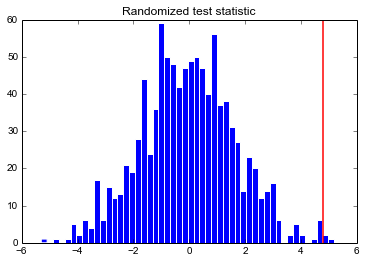

In [56]:
# Now let's run the actual iterations
randomizeN([a,b], N=1000, show=True, bench=np.mean(a)-np.mean(b))

Here we see that the observed effect is essentially the largest possible combination of samples. The value above is a valid, non-parametric reportable p-value substitute that is recognized by most journals.

This method retains the original sample distribution -- and in fact uses the example same values. It is the most conservative possible statistical test as it requires no priors or constraints.

** We also know that this result is robust, for the same reason we know the p-values calculated in the first example were not robust.**

## Bootstrapping

Strictly speaking, bootstrap sampling is extremely similar to randomization. Bootsrapping (in this sense) provides for replacement, so that if you have $A_i, i=1,2,...$ and wanted to create an artificial group $X_A$, you could have $X_A = {a_1, a_2, a_1, ...}$ -- that is, the members of $X_A$ need not be unique; once you use a value from $A$, you replace it back into the pool and can use it again. 

This allows for samples to grow much larger that their original sizes while altering the distribution in the most conservative way possible (compared to drawing from random distributions or distributions already fit to the data at hand).

We can try the above example with bootstrap resampling to see if there is any difference -- we wouldn't expect much. Bootstrapping comes in handy later.

In [15]:
# We'll use the same function as above, but with optional replacement
def scramble(groups, replacement=True):
    lenA, lenB = len(groups[0]), len(groups[1])
    pooled = list(groups[0])+list(groups[1])
    # Create the indexing lists for the new groups
    scram = []
    while len(scram) < len(pooled):
        ix = int(np.random.random(1)*len(pooled))
        if replacement: # Replacement okay
            scram.append(ix)
        else: # No replacement
            if ix not in scram:
                scram.append(ix)
    randA = [pooled[scram[i]] for i in range(0,lenA)]
    randB = [pooled[scram[i]] for i in range(lenA, len(pooled))]
    #print(randB)
    return [randA, randB]

# Same as above, but with replacement
def randomizeN(groups, N=1000, show=True, bench=None):
    diffs = [] # Store the differences in means here
    for i in range(N):
        diffs.append(test_stat(scramble(groups, True)))
    # We can plot what these results look like
    fig = plt.figure()
    ax = fig.add_subplot(111)
    hist, _ = np.histogram(diffs, bins=5)
    ax.hist(diffs, bins=50, facecolor='b', edgecolor='white')
    ax.set_title('Randomized test statistic')
    # We can also plot a benchmark, such as our observed difference
    if bench is not None:
        ax.axvline(bench, 0, max(hist), color='r', lw=1.5)
        # Also calculate a "p-value"
        sim_effect = len([i for i in diffs if i >= bench])
        print('The observed effect was larger than %.2f %% of samples.'
              %(1-float(sim_effect)/len(diffs)*100))
    if show:
        plt.show()
    return

The observed effect was larger than 0.90 % of samples.


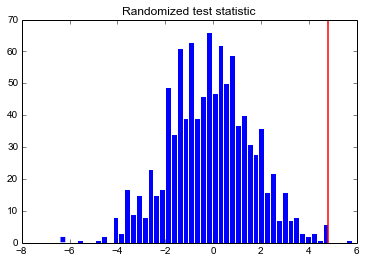

In [16]:
# Now we'll test it
a, b = jackaldata()
randomizeN([a,b], N=1000, show=True, bench=np.mean(a)-np.mean(b))

As expected, the result is basically the same.

## Monte Carlo simulation

Monte Carlo basically means using randomness to examine whether the observed data fall outside the likely values generated by random processes. 

In the simplest cases, we can simply use random distributions to generate data and compare with the observed data. More complicated applications can use random data to influence a parameter or operation that acts on test data, such as with Markov chains.

As a simple example, let's consider some data from Al's recent paper (Hamood & Marder, J Neurophys, 2015) where he notes that pyloric cycles per LG cycle cluster at integer values. His data look something like this:

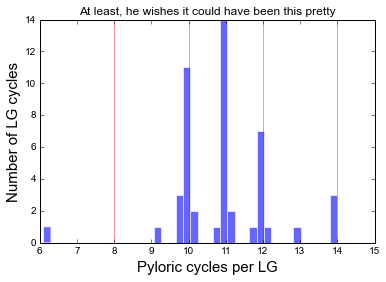

In [17]:
# Fake data that look exactly like Al's real data
fake = [6.1, 9.2, 9.9, 9.8, 9.8, 9.8, 9.9, 9.9, 9.9, 9.9,
        10., 10., 10., 10., 10., 10., 10.1,10.1, 10.8, 10.9,
         10.9, 10.9, 10.9, 10.9, 10.9, 10.9, 11.0, 11.0, 11.0, 
         11.0, 11.0, 11.0, 11.0, 11.2, 11.2, 11.8, 12., 12., 
         12., 12., 12., 12., 12., 12.2, 12.9, 13.9, 14., 14.]
# Which look something like this
plt.hist(fake, bins=40, facecolor='b', edgecolor='white', alpha=0.6)
for i in [8,10,12,14]:
    plt.axvline(i, 0, 20, color='r', alpha=0.4)
plt.xlabel('Pyloric cycles per LG', fontsize=15)
plt.ylabel('Number of LG cycles', fontsize=15)
plt.title('At least, he wishes it could have been this pretty')

We can show this wasn't a result of random integer clustering by generating noisy integer data for integers between 6 and 15.

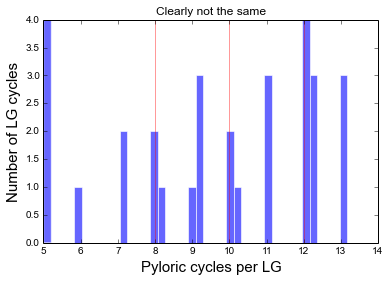

In [18]:
# Generate some random data
gaus_int = [int(u) for u in np.random.random(50)*max(fake) if u > 5.]
gaus_int = [float(u)+np.random.random(1)*.2 for u in gaus_int]
gaus_int = [i[0] for i in gaus_int]
# And shoe the results
plt.hist(gaus_int, bins=40, facecolor='b', edgecolor='white', alpha=0.6)
for i in [8,10,12,14]:
    plt.axvline(i, 0, 20, color='r', alpha=0.4)
plt.xlabel('Pyloric cycles per LG', fontsize=15)
plt.ylabel('Number of LG cycles', fontsize=15)
plt.title('Clearly not the same')

But with a noisy Poisson distribution...

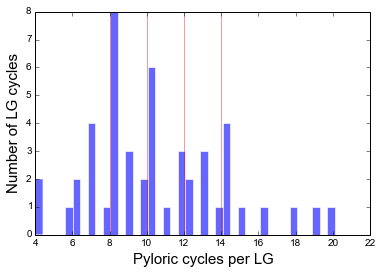

In [21]:
# Make a noisy poisson distribution
def noisy_poisson(distin, modadder=0.15):
    # modadder controls how much non-integer-ness is added (max=1.)
    distout = np.random.poisson(lam=np.mean(distin), size=len(distin))
    distout = [int(i)+np.random.random(1)*modadder for i in distout]
    return [i[0] for i in distout]

# Generate and pPlot the distribution
pois_int = noisy_poisson(fake, modadder=0.2)
plt.hist(pois_int, bins=40, facecolor='b', edgecolor='white', alpha=0.6)
for i in [8,10,12,14]:
    plt.axvline(i, 0, 20, color='r', alpha=0.4)
plt.xlabel('Pyloric cycles per LG', fontsize=15)
plt.ylabel('Number of LG cycles', fontsize=15)
plt.title('')

We can probe the goodness of fit of this distribution by looking at a few test statistics across several iterations.

The observed effect was larger than -55.40 % of samples.


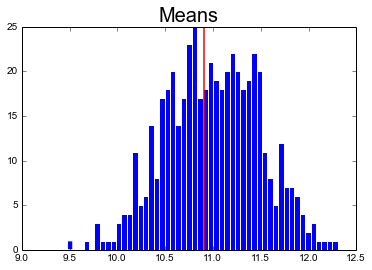

In [22]:
# Simple histogram plotting function
def plot_dist(dist, show=True, bench=None, title=None, nbins=50):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    hist, _ = np.histogram(dist, bins=5)
    ax.hist(dist, bins=nbins, facecolor='b', edgecolor='white')
    ax.set_title(title, fontsize=20)
    # We can also plot a benchmark, such as our observed difference
    if bench is not None:
        ax.axvline(bench, 0, max(hist), color='r', lw=1.5)
        # Also calculate a "p-value"
        sim_effect = len([i for i in dist if i >= bench])
        print('The observed effect was larger than %.2f %% of samples.'
              %(1-float(sim_effect)/len(dist)*100))
    if show:
        plt.show()
    return

# First, create many sample distributions
many_dists = [noisy_poisson(fake) for i in range(500)]
# Show the means of these distributions
means = [np.mean(u) for u in many_dists]
plot_dist(means, show=True, bench=np.mean(fake), title='Means')

The observed effect was larger than -64.80 % of samples.


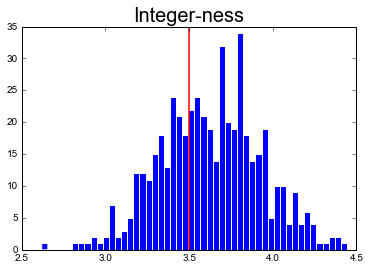

In [23]:
# How about the integer-ness of the distribution?
def sum_mods(dist): # This function sums the mods from each distribution
    return sum([i%1. if i%1.<=0.5 else 1-(i%1.) for i in dist])

# many_dists = 
mods = [sum_mods(u) for u in many_dists]
plot_dist(mods, show=True, bench=sum_mods(fake), title='Integer-ness', nbins=50)

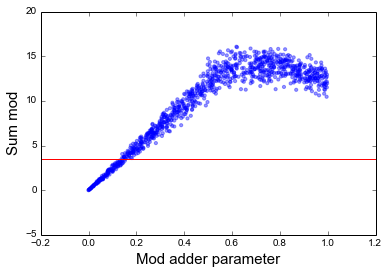

In [24]:
# We can use this process to estimate the parameter modadder
madders = np.random.random(1000)
madders_dists = [noisy_poisson(fake, modadder=m) for m in madders]
madder_mods = [sum_mods(u) for u in madders_dists]

# And plot the relationship
plt.scatter(madders, madder_mods, marker='o', color='b', 
            s=10, alpha=0.4)
plt.axhline(sum_mods(fake), 0,max(madders), color='r')
plt.xlabel('Mod adder parameter', fontsize=15)
plt.ylabel('Sum mod', fontsize=15)


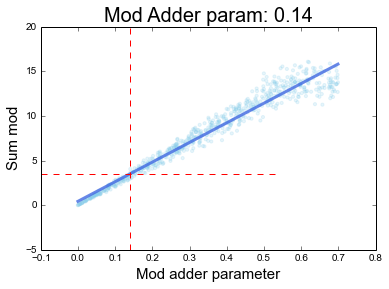

In [25]:
# For completeness, we could find exactly what this parameter should be
# Use a simple linear regression
def basic_linear_regression(x, y, replicates=False):
  if replicates == False:
    # sum(x^2) and sum(xy)
    x_SS = sum(map(lambda a: a * a, x))
    covariance_SS = sum([x[i] * y[i] for i in range(len(x))])
    
    b = (covariance_SS - (sum(x) * sum(y)) / len(x)) / (x_SS - \
                                          ((sum(x)**2) / len(x)))
    a = (sum(y) - b*sum(x))/len(x)
  
  # replicates == True
  else:
    x_sum, y_sum = sum(map(lambda a: a * a, x)), sum(map(lambda a: a*a,y))
    x_mean, y_mean = np.mean(x), np.mean(y)
    x_SS = x_sum - sum(x)**2/len(x)
    xy_sum = sum([x[i]*y[i] for i in range(len(x))])
    xy_SS = xy_sum - sum(x) * sum(y) / len(x)
    b = float(xy_SS) / x_SS
    a = y_mean - b*x_mean
  
  return a, b

# Get the fit, plot it, and find the value
dat = np.array([madders, madder_mods])
dat[dat[:,0].argsort()]
# Since we know the fit is near the beginning, leave out past 0.7
madders = [dat[0,i] for i in range(len(dat[0])) if dat[0,i] < 0.7]
madder_mods = [dat[1,i] for i in range(len(dat[0])) if dat[0,i] < 0.7]
a, b = basic_linear_regression(madders, madder_mods)
x = np.linspace(min(madders), max(madders), 100)
y = [i*b + a for i in x]
argmin = [abs(i-sum_mods(fake)) for i in y]
xval = x[argmin.index(min(argmin))]
plt.scatter(madders, madder_mods, marker='o', color='skyblue', 
            s=10, alpha=0.2)
plt.plot(x,y,lw=3, c='royalblue', alpha=0.8)
plt.axhline(sum_mods(fake), 0,max(madders), color='r', ls='--')
plt.axvline(xval, 0, max(madder_mods), color='r', ls='--')
plt.xlabel('Mod adder parameter', fontsize=15)
plt.ylabel('Sum mod', fontsize=15)
plt.title('Mod Adder param: %.2f' %xval, fontsize=20)

Knowing these parameters, one could then make distributions of data to test against the observed data. For Monte Carlo testing, we have to make sure the data are realistic enough to hold up to cursory scrutiny, while still making the fewest assumptions and constraints possible. 

We have a way of generating millions of data sets to compare against the observed data. Whenever the observed data is an outlier, it can mean our model is failing to capture something biology is doing, which should provide insight into *what* biology is doing. 

(As Tim is fond of saying, the goal of a model isn't to make predictions but to help us understand what is happening.)

# Confidence intervals done right

## Confidence intervals
And what confidence intervals *do not* mean:
* a confidence interval is *not* the interval within which there is a 95% chance that a true (population) parameter lies. 
* it does *not* mean that there is a 95% chance the interval covers the population parameters.
* it does *not* mean that 95% of the sample data lie within the interval.
* it is *not* a range of plausible values for the sample mean, and
* it does *not* mean that replicated experiments have a 95% chance of falling within the interval.

Actually the confidence interval is the percent of confidence intervals taken from different samples that will contain the true parameter. For example, if an experiment generates a 95% confidence interval of [a,b], this implies that 95% of the confidence intervals extrapolated from similar experiments (-- literally, data of this type --) will contain the true value in their confidence intervals. So if the experiment were repeated another 19 times, 19 of the 20 generated confidence intervals would contain the true value of the parameters. 

As an example, consider the jackals.

Mean: 113.400, 0.95 CI: 110.740 - 116.060
Mean: 108.600, 0.95 CI: 106.976 - 110.224


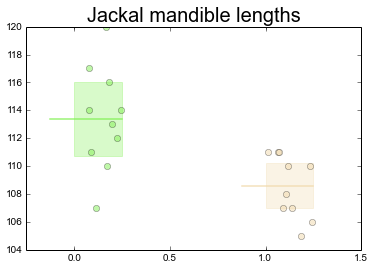

In [26]:
a, b = jackaldata()

# Show groups of data with or without confidence intervals
def show_data(groups, conf=0.95, retax=False, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for g in groups:
        ix = groups.index(g)
        col = np.random.random(3)
        ax.plot(np.random.random(len(g))*.25+ix, 
                 g, 'o', color=col, alpha=0.5, )
        ax.plot([-.125+ix,.25+ix], [np.mean(g), np.mean(g)],
              linewidth=1.5, color=col, alpha=0.8)
        if conf is not None:
            low, upp = stats.t.interval(conf, len(g)-1, loc=np.mean(g),
                                        scale=stats.sem(g))
            ax.fill_between([ix,ix+.25], low, upp, color=col, alpha=0.3)
            print('Mean: %.3f, %.2f CI: %.3f - %.3f'
                  %(np.mean(g), conf, low, upp))
    ax.set_title(title, fontsize=20)
    ax.set_xticks(range(len(groups)), 
                  ['ABCDEFG'[i] for i in range(len(groups))])
    ax.set_xlim([-.25,-.5+len(groups)])
    # ax.set_ylim([0,5])
    if retax:
        return ax
    else:
        plt.show(); return

show_data([a,b], conf=0.95, title='Jackal mandible lengths')

But these CIs are calculated with the expectation that (at least) another 19 experiments will be run -- the necessary minimum to get a 5% CI resolution.

By bootstrapping the data we can generate more accurate and *meaningful* CIs -- we know *how* they are generated and we understand *why*. Those points are important because you couldn't convince me why conventional CIs matter or that their estimation is logical.

Bootstrapped CIs:
Mean: 113.400, 0.95 CI: 111.200 - 115.600
Mean: 108.600, 0.95 CI: 107.300 - 109.900


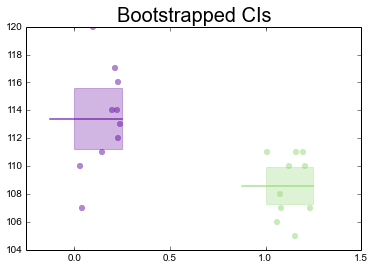

In [27]:
# Here is the bootstrap function. Note: we can pass it any member function
def bootstrap(data, num_samples=100000, statistic=np.mean, alpha=0.05):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    data = np.array(data)
    n = len(data)
    # Generate num_samples random ints from 0-len(data)
    idx = np.random.randint(0, n, (num_samples, n))
    # Use these ints to populate num_samples bootstrapped arrays
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    # Sort them to return the samples falling in the CI
    return (stat[int((alpha/2.0)*num_samples)], # Lower
            stat[int((1-alpha/2.0)*num_samples)]) # Upper

# This integrates the bootstrap code into the plotting function
def show_data_boot(groups, conf=0.95, retax=False, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for g in groups:
        ix = groups.index(g)
        col = np.random.random(3)
        ax.plot(np.random.random(len(g))*.25+ix, 
                 g, 'o', color=col, alpha=0.5, markeredgecolor='none')
        ax.plot([-.125+ix,.25+ix], [np.mean(g), np.mean(g)],
              linewidth=1.5, color=col, alpha=0.8)
        if conf is not None:
            low, upp = bootstrap(g, statistic=np.mean, alpha=1-conf)
            ax.fill_between([ix,ix+.25], low, upp, color=col, alpha=0.3)
            print('Mean: %.3f, %.2f CI: %.3f - %.3f'
                  %(np.mean(g), conf, low, upp))
    ax.set_title(title, fontsize=20)
    ax.set_xticks(range(len(groups)), 
                  ['ABCDEFG'[i] for i in range(len(groups))])
    ax.set_xlim([-.25,-.5+len(groups)])
    # ax.set_ylim([0,5])
    if retax:
        return ax
    else:
        plt.show(); return

# Now we'll run this with the jackal data to generate CIs
print('Bootstrapped CIs:')
show_data_boot([a,b], title='Bootstrapped CIs')

Conventional CIs:
Mean: 113.400, 0.95 CI: 110.740 - 116.060
Mean: 108.600, 0.95 CI: 106.976 - 110.224


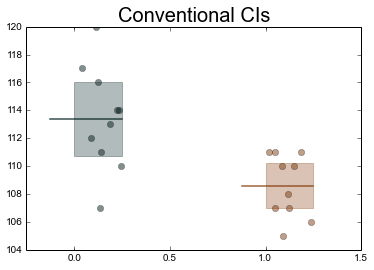

In [171]:
# To see the differences:
print('Conventional CIs:')
show_data([a,b], conf=0.95, title='Conventional CIs', 
          retax=True)


These CIs might be identical or slightly different, but that doesn't matter. What matters is that they mean to us, intuitively and computationally. There's no black box.

## Jackknife confidence intervals

Similar to bootstrapped CIs, he leave-one-out jackknife allows re-sampling of a finite data set to obtain CIs. It also serves to correct for bias since each computation allows one sample to be removed, thereby reducing variance in several cases. Here we show it again with the jackal data.

Jackknife CI:
Mean: 113.400, 0.95 CI: 112.667 - 114.111
Mean: 108.600, 0.95 CI: 107.571 - 109.000


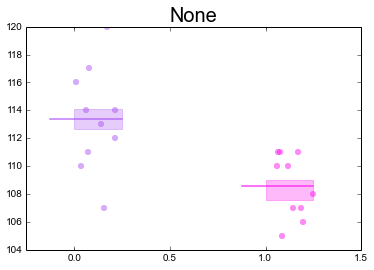

In [188]:
# Here's the jackknife function
def jackknife(data, statistic=np.mean, alpha=0.05):
    # We allow any reasonable function to be passed as the statistic
    n = len(data)
    sets = [[u for u in data if data[i] != u] for i in range(n)]
    stat = np.sort([statistic(u) for u in sets])
    # Sort them to return the samples falling in the CI
    return (stat[int((alpha/2.0)*n)], # Lower
            stat[int((1-alpha/2.0)*n)]) # Upper
    
# Plot the findings
def show_data_jack(groups, conf=0.95, retax=False, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for g in groups:
        ix = groups.index(g)
        col = np.random.random(3)
        ax.plot(np.random.random(len(g))*.25+ix, 
                 g, 'o', color=col, alpha=0.5, markeredgecolor='none')
        ax.plot([-.125+ix,.25+ix], [np.mean(g), np.mean(g)],
              linewidth=1.5, color=col, alpha=0.8)
        if conf is not None:
            low, upp = jackknife(g, statistic=np.mean, alpha=1-conf)
            ax.fill_between([ix,ix+.25], low, upp, color=col, alpha=0.3)
            print('Mean: %.3f, %.2f CI: %.3f - %.3f'
                  %(np.mean(g), conf, low, upp))
    ax.set_title(title, fontsize=20)
    ax.set_xticks(range(len(groups)), 
                  ['ABCDEFG'[i] for i in range(len(groups))])
    ax.set_xlim([-.25,-.5+len(groups)])
    # ax.set_ylim([0,5])
    if retax:
        return ax
    else:
        plt.show(); return

# Now plot these things
print('Jackknife CI:')
show_data_jack([a,b],)

These samples are awful candidates for jackknifing because their size is so small. With a larger sample the change in CI is not so large:

Bootstrapped CIs:
Mean: 113.050, 0.95 CI: 112.237 - 113.875
Mean: 107.354, 0.95 CI: 106.954 - 107.754


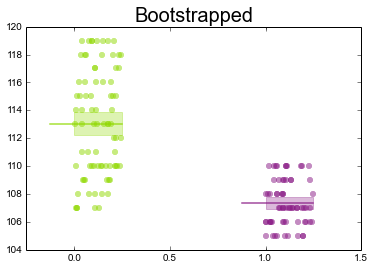

Jackknife CIs:
Mean: 113.050, 0.95 CI: 112.389 - 113.642
Mean: 107.354, 0.95 CI: 106.873 - 107.732


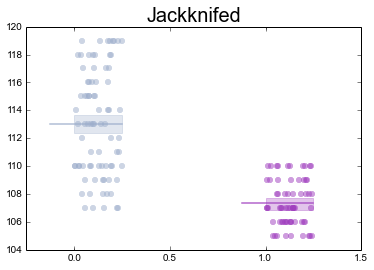

In [193]:
# Generate fake jackal data
xA = np.random.randint(min(a), max(a), size=80)
xB = np.random.randint(min(b), max(b), size=65)
print('Bootstrapped CIs:')
show_data_boot([xA, xB], title='Bootstrapped')
print('Jackknife CIs:')
show_data_jack([xA, xB], title='Jackknifed')

## Sources

** Chan, C** *Data analysis with Python -- Practical computing for biologists.* http://people.duke.edu/~ccc14/pcfb/analysis.html

**Manly, B** *Randomization, Bootstrap and Monte Carlo methods in Biology.*

**Pilon, CD** *Probabilistic programming and Bayesian methods for Hackers.* http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master/

**Vanderplas, J** *Frequentism and Bayesianism: A Python-driven Primer.* http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/
(Also an associated paper on arXiv: http://arxiv.org/abs/1411.5018)